In [1]:
import pandas as pd
import numpy as np
import math
import pickle
from sqlalchemy import create_engine
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor

In [2]:
# データベースの情報
server = 'gciteam16.database.windows.net'
database = 'mynavi-database'
username = 'gciteam16'
password = 'Password0'
port =1433

In [3]:
# 接続エンジンの作成
engine_config = "?driver=ODBC+Driver+13+for+SQL+Server?charset=shift-jis"
db_settings = {
    "host": server,
    "database": database,
    "user": username,
    "password": password,
    "port":port,
    "config_query":engine_config
}
engine = create_engine('mssql+pyodbc://{user}:{password}@{host}:{port}/{database}{config_query}'.format(**db_settings))

In [4]:
query = "SELECT * FROM analytical_data_table"
analytical_data = pd.read_sql(query, con=engine)

# 分析データの確認

<h3>データ整形

In [5]:
X = analytical_data.iloc[:,3:]
y = analytical_data.iloc[:,:3].rent
X_col = X.columns

<h3>予測モデルの読み込み

In [6]:
with open('../../gci_project_storage/RF_models.pickle', mode='rb') as f:
     RF_models = pickle.load(f)

In [7]:
RF_avoid_0_to_7682 = RF_models["RF_avoid_0_to_7682"]
RF_avoid_7682_to_15364 = RF_models["RF_avoid_7682_to_15364"]
RF_avoid_15364_to_23046 = RF_models["RF_avoid_15364_to_23046"]
RF_avoid_23046_to_30728 = RF_models["RF_avoid_23046_to_30728"]
RF_whole_data = RF_models["RF_whole_data"]

In [2]:
with open('../../gci_project_storage/train_data_urls.pickle', mode='rb') as f:
    train_data_urls = pickle.load(f)

In [5]:
train_data_urls.to_csv("../Web_Server/storage/train_data_urls.csv",encoding="utf-8")

In [9]:
#予測値を出す関数
def get_pred(DF_analytical_data):
    if(list(DF_analytical_data.url)[0] in list(train_data_urls.iloc[pd.Series(range(0,7682))])):
        #print(1)
        return RF_avoid_0_to_7682.predict(DF_analytical_data.iloc[:,3:])[0]
    if(list(DF_analytical_data.url)[0] in list(train_data_urls.iloc[pd.Series(range(7682,15364))])):
        #print(2)
        return RF_avoid_7682_to_15364.predict(DF_analytical_data.iloc[:,3:])[0]
    if(list(DF_analytical_data.url)[0] in list(train_data_urls.iloc[pd.Series(range(15364,23046))])):
        #print(3)
        return RF_avoid_15364_to_23046.predict(DF_analytical_data.iloc[:,3:])[0]
    if(list(DF_analytical_data.url)[0] in list(train_data_urls.iloc[pd.Series(range(23046,30728))])):
        #print(4)
        return RF_avoid_23046_to_30728.predict(DF_analytical_data.iloc[:,3:])[0]
    else:
        #print(5)
        return RF_whole_data.predict(DF_analytical_data.iloc[:,3:])[0]

In [10]:
DF_analytical_data = analytical_data[analytical_data.index==3312]
get_pred(DF_analytical_data)

5.2400000000000002

<h3>緯度経度で半径500mの物件を選択

In [11]:
#緯度・経度のスケール
lat_mean = analytical_data.address_lat.mean()
lat_500m = (90/10000)*(1/math.cos(math.pi*lat_mean/180))*0.500
lng_500m = (90/10000)*0.500

In [12]:
arg_dict = {
    "lat_500m" : lat_500m
    ,"lng_500m" : lng_500m
    ,"sup_lat" : list(DF_analytical_data.address_lat)[0] + lat_500m
    ,"inf_lat" : list(DF_analytical_data.address_lat)[0] - lat_500m
    ,"sup_lng" : list(DF_analytical_data.address_lng)[0] + lng_500m
    ,"inf_lng" : list(DF_analytical_data.address_lng)[0] - lng_500m
    ,"DF_analytical_data_lat" : list(DF_analytical_data.address_lat)[0]
    ,"DF_analytical_data_lng" : list(DF_analytical_data.address_lng)[0]
}


query = """
    SELECT * FROM 
        (
        SELECT * FROM analytical_data_table 
            WHERE 
                (address_lat < {sup_lat}) 
                and (address_lat > {inf_lat})
                and (address_lng < {sup_lng})
                and (address_lng > {inf_lng}) 
        ) as Sub_Table
        WHERE 
            SQUARE((Sub_Table.address_lat-{DF_analytical_data_lat})/{lat_500m})
            + SQUARE((Sub_Table.address_lng-{DF_analytical_data_lng})/{lng_500m}) 
            < 1
    ;
    """.format(**arg_dict)

regional_data = pd.read_sql(query, con=engine)

In [13]:
regional_data.shape

(136, 435)

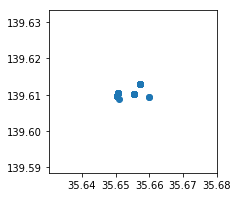

In [14]:
plt.figure(figsize=(3,3))
plt.scatter(regional_data.address_lat,regional_data.address_lng)
plt.show()

<h3>予測値を追加

In [15]:
df_new = regional_data[["rent","area","address_lat","address_lng","year_built"]]
df_new.columns = ["価格(家賃)","床面積","緯度","経度","築年"]

In [17]:
y_pred_regional=[get_pred(row.to_frame().T) for i,row in regional_data.iterrows()]
df_new["予測価格"] = y_pred_regional

C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [18]:
df_new["割引率(％)"] = round((1-regional_data.rent/y_pred_regional)*1000)/10

C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [19]:
df_new.shape

(136, 7)

<h3>最寄り駅を追加

In [2]:
station_names = regional_data.columns[148:435]

get_min_inverse_to_station = lambda row_of_regional_data: row_of_regional_data[148:435].max()
get_min_to_station = lambda row_of_regional_data:round(1.0/get_min_inverse_to_station(row_of_regional_data)) if get_min_inverse_to_station(row_of_regional_data)<=1 else 0
get_min_station = lambda row_of_regional_data: list(station_names[get_min_inverse_to_station(row_of_regional_data)==row_of_regional_data[148:435]])[0]

NameError: name 'regional_data' is not defined

In [21]:
df_new["最寄駅"] = pd.Series([get_min_station(row) for i,row in regional_data.iterrows()])
df_new["最寄駅への所要時間"] = pd.Series([get_min_to_station(row) for i,row in regional_data.iterrows()])

C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


<h3>離散変数の処理

In [23]:
#間取り…やり直し！
def get_room_structure(row):
    get_row_by = lambda colname:list(row[regional_data.columns==colname])[0]
    txt = ''
    txt += str(get_row_by("the_number_of_rooms"))
    txt += 'L' if get_row_by("has_L") else ''
    txt += 'D' if get_row_by("has_D") else ''
    txt += 'K' if get_row_by("has_K") else ''
    return txt

df_new["間取り"] = pd.Series([get_room_structure(row) for i,row in regional_data.iterrows()])

C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [24]:
def get_direction(row):
    get_row_by = lambda colname:list(row[regional_data.columns==colname])[0]
    if get_row_by("direction_1"): return '北'
    if get_row_by("direction_2"): return '北東'
    if get_row_by("direction_3"): return '東'
    if get_row_by("direction_4"): return '南東'
    if get_row_by("direction_5"): return '南'
    if get_row_by("direction_6"): return '南西'
    if get_row_by("direction_7"): return '西'
    if get_row_by("direction_8"): return '北西'
    else: return "方角不明"

df_new["方角"] = pd.Series([ get_direction(row) for i,row in regional_data.iterrows()])

C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [25]:
def get_structure(row):
    get_row_by = lambda colname:list(row[regional_data.columns==colname])[0]
    if get_row_by("structure_1"): return 'コンクリート'
    if get_row_by("structure_2"): return 'コンクリート'
    if get_row_by("structure_3"): return 'コンクリート'
    if get_row_by("structure_4"): return 'コンクリート'
    if get_row_by("structure_5"): return 'コンクリート'
    if get_row_by("structure_7"): return '鉄骨'
    if get_row_by("structure_8"): return '鉄骨'
    if get_row_by("structure_9"): return '鉄骨'
    if get_row_by("structure_10"): return '木造'
    else: return 'その他'

df_new["建物構造"] = pd.Series([ get_structure(row) for i,row in regional_data.iterrows()])

C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [26]:
def get_stove_num(row):
    get_row_by = lambda colname:list(row[regional_data.columns==colname])[0]
    if get_row_by("isNull_stove_num"): return 'コンロ口数不明'
    else: return get_row_by("stove_num_Null_to_Zero")

df_new["コンロ口数"] = pd.Series([get_stove_num(row) for i,row in regional_data.iterrows()])

C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [27]:
df_new["浴室乾燥機"] = regional_data.bath_drier_Null_to_Zero.apply(lambda TF:'浴室乾燥機あり' if TF else '浴室乾燥機なし')
df_new["オートロック"] = regional_data.auto_lock.apply(lambda TF:'オートロックあり' if TF else 'オートロックなし')
df_new["フローリング"] = regional_data.flooring.apply(lambda TF:'フローリング〇' if TF else 'フローリング×')


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http:/

In [28]:
df_new.head()

,価格(家賃),床面積,緯度,経度,築年,予測価格,割引率(％),最寄駅,最寄駅への所要時間,間取り,方角,建物構造,コンロ口数,浴室乾燥機,オートロック,フローリング
0,5.55,20.53,35.655598,139.610286,1992.0,6.443500,13.9,千歳烏山駅,16.0,1DK,南,鉄骨,2,浴室乾燥機なし,オートロックなし,フローリング〇
1,5.50,24.32,35.655598,139.610286,1991.0,6.707500,18.0,祖師ケ谷大蔵駅,17.0,1K,方角不明,鉄骨,1,浴室乾燥機なし,オートロックなし,フローリング〇
2,5.00,21.00,35.650482,139.609662,1980.0,5.215000,4.1,祖師ケ谷大蔵駅,8.0,1K,東,木造,0,浴室乾燥機なし,オートロックなし,フローリング〇
3,11.90,58.57,35.655598,139.610286,2013.0,14.201125,16.2,祖師ケ谷大蔵駅,21.0,2LDK,西,木造,2,浴室乾燥機あり,オートロックなし,フローリング〇
4,12.40,57.46,35.657267,139.613019,1994.0,12.405000,0.0,千歳烏山駅,20.0,2LDK,東,コンクリート,0,浴室乾燥機なし,オートロックあり,フローリング〇


<h3>選択された物件にタグ付け

In [29]:
tag_property = lambda TF:"選択された物件" if TF else "周囲の物件 (500m県内) "
df_new["選択物件"] = (regional_data.url==list(DF_analytical_data.url)[0]).apply(tag_property)


C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [30]:
txt_to_render = ""
IF_start = True
for i,row in df_new.iterrows():
    get_row_by = lambda colname:list(row[df_new.columns==colname])[0]
    if IF_start==False:
        txt_to_render += ",\n"
    txt_to_render += "{"
    IF_start = False
    if_start = True
    for colname in df_new.columns:
        if if_start==False:
            txt_to_render += ","
        if_start = False
        txt_to_render += "\"{colname}\":\"{value}\"".format(colname=colname,value=get_row_by(colname))
    txt_to_render += "}"

In [31]:
txt_to_render = "[\n" + txt_to_render + "\n]"

In [32]:
print(txt_to_render)

[
{"価格(家賃)":"5.55","床面積":"20.53","緯度":"35.6555979","経度":"139.6102864","築年":"1992.0","予測価格":"6.443500000000001","割引率(％)":"13.9","最寄駅":"千歳烏山駅","最寄駅への所要時間":"16.0","間取り":"1DK","方角":"南","建物構造":"鉄骨","コンロ口数":"2.0","浴室乾燥機":"浴室乾燥機なし","オートロック":"オートロックなし","フローリング":"フローリング〇","選択物件":"周囲の物件 (500m県内) "},
{"価格(家賃)":"5.5","床面積":"24.32","緯度":"35.6555979","経度":"139.6102864","築年":"1991.0","予測価格":"6.707500000000002","割引率(％)":"18.0","最寄駅":"祖師ケ谷大蔵駅","最寄駅への所要時間":"17.0","間取り":"1K","方角":"方角不明","建物構造":"鉄骨","コンロ口数":"1.0","浴室乾燥機":"浴室乾燥機なし","オートロック":"オートロックなし","フローリング":"フローリング〇","選択物件":"周囲の物件 (500m県内) "},
{"価格(家賃)":"5.0","床面積":"21.0","緯度":"35.650482000000004","経度":"139.6096618","築年":"1980.0","予測価格":"5.215","割引率(％)":"4.1","最寄駅":"祖師ケ谷大蔵駅","最寄駅への所要時間":"8.0","間取り":"1K","方角":"東","建物構造":"木造","コンロ口数":"0.0","浴室乾燥機":"浴室乾燥機なし","オートロック":"オートロックなし","フローリング":"フローリング〇","選択物件":"周囲の物件 (500m県内) "},
{"価格(家賃)":"11.9","床面積":"58.57","緯度":"35.6555979","経度":"139.6102864","築年":"2013.0","予測価格":"14.201125000000008","割引率(％)":"16.2","最寄駅":"祖師